In [1]:
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt

In [2]:
face_replace =  cv2.imread(os.path.relpath('../../Data/TedCartoon.png'))
face_replace  = cv2.cvtColor(face_replace ,cv2.COLOR_BGR2RGB)


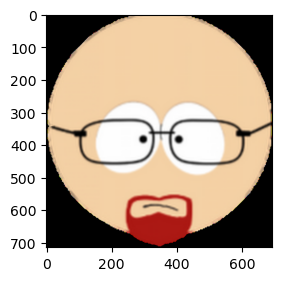

In [3]:
plt.subplot(121); plt.imshow(face_replace)


In [4]:
# Load the pre-trained face detection classifier
face_cascade=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
#mouth_cascade = cv2.CascadeClassifier('haarcascade_mcs_mouth.xml')

class KalmanFilter(object):
    def __init__(self, F = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H

        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self):
        self.x = np.matmul(self.F, self.x)
        self.P = np.matmul(np.matmul(self.F, self.P), self.F.transpose()) + self.Q
        return self.x

    def update(self, z):
        y = z - np.matmul(self.H, self.x)
        S = self.R + np.matmul(self.H, np.matmul(self.P, self.H.transpose()))

        K = np.matmul(np.matmul(self.P, self.H.transpose()), np.linalg.inv(S))
        self.x = self.x + np.matmul(K, y)
        I = np.eye(self.n)
        self.P = np.matmul(np.matmul(I - np.matmul(K, self.H), self.P), 
        	(I - np.matmul(K, self.H)).transpose()) + np.matmul(np.matmul(K, self.R), K.transpose())
        

def transfer_face(frame,face_replace,kfilt):
    # template_markers
    #  left eye
    #  right eye
    #  mouth
    #  upper-left corner
    #  upper-right corner
    #  lower-right corner
    #  lower-left corner
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray,1.3,5,minSize=(30,30))
    face_replace2  = cv2.cvtColor(face_replace ,cv2.COLOR_RGB2BGR)

    for (x,y,w,h) in faces:

        xx = np.zeros((4,1))
        xx[0,0]=x
        xx[1,0]=y
        xx[2,0]=w
        xx[3,0]=h

        kfilt.update(xx)

    xx=kfilt.predict()
   
    x=np.uint32(xx[0,0])
    y=np.uint32(xx[1,0])
    w=np.uint32(xx[2,0])
    h=np.uint32(xx[3,0])

    if(x>0 and y>0 and w>0 and h>0):            
        roi_color =frame[y:y+h, x:x+w]
        face=cv2.resize(face_replace2,roi_color.shape[:2])
        lst=np.where(face>30)
        roi_color[lst] = face[lst]


    # roi_gray = gray[y:y+h, x:x+w]
    # eyes = eye_cascade.detectMultiScale(roi_gray)
    # for (ex,ey,ew,eh) in eyes:
    #     cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)   
        
    # mouth = mouth_cascade.detectMultiScale(roi_gray)
    # for (ex,ey,ew,eh) in mouth:
    #    cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,0,255),2)

    return frame



[ERROR:0@1.784] global persistence.cpp:531 open Can't open file: 'haarcascade_frontalface_default.xml' in read mode


In [5]:
kfilt = KalmanFilter(F=np.eye(4),H=np.eye(4),Q=np.eye(4),R=np.eye(4)*2)


alive = True

win_name = "Face Replace"
cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)
result = None
source = cv2.VideoCapture(0)

while alive:
    has_frame, frame= source.read()
    if not has_frame:
        break
    
    # Read the image

    image = transfer_face(frame,face_replace,kfilt)

    cv2.imshow(win_name,image)

    key = cv2.waitKey(1)
    if key == ord("Q") or key == ord("q") or key == 27:
        alive = False

cv2.destroyAllWindows()

[ WARN:0@3.305] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


error: OpenCV(4.10.0) /private/var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_8fnr0qj6yr/croot/opencv-suite_1722029127451/work/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'
